# Is the rise in surface pressure a boundary condition flaw?

In [8]:
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
# module_path = '/Users/admin/warm_eurec4a/submodules'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units 
import postprocessing as pp
import calculations as cc

def print_filesize_summary(paths = [
        '/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
        '/work/mh1126/m300872/moist_adiabatic/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
        '/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc',
        '/work/mh1126/m300872/moist_adiabatic/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010812.nc']):
    summe = 0
    for path in paths:
        file_size = os.path.getsize(path) / 1e6
        summe += file_size
        print(int(file_size), 'MB')
    print(f'sum = {int(summe)} MB')

def stamp(): return '202403'

def create_bcprofiles():
    save_paths = [f'data/profile_ctrl_latbc_{stamp()}.nc', 
                  f'data/profile_warm_latbc_{stamp()}.nc', 
                  f'data/profile_ctrl_initcon_{stamp()}.nc', 
                  f'data/profile_warm_initcon_{stamp()}.nc']
    data_paths = ['/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
                  '/work/mh1126/m300872/moist_adiabatic/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc',
                  '/work/mh1126/m300872/unchanged/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010801.nc',
                  '/work/mh1126/m300872/moist_adiabatic/latbc/20200108/latbc_EUREC4A_PR1250m_DOM01_2020010812.nc']
    
    def body(ifile,ofile):
        python_header = [
            'import os',
            'import sys',
            "module_path = '/home/m/m300872/warm_eurec4a/submodules/'",
            'if not module_path in sys.path: sys.path.append(module_path)',
            'import file_handling as fh',
            'import numpy as np',
            'import xarray as xr',
            'import metpy.calc as mpcalc',
            'from metpy.units import units',
            'import postprocessing as pp',
            'import calculations as cc',
            '']
        body = [
            f"ifile = '{ifile}'", 
            f"ofile = '{os.path.join(os.getcwd(), ofile)}'",
            '',
            "data = xr.open_dataset(ifile).isel(time=0)",
            "dims = [dim for dim in data.dims if 'cell' in dim]",
            "data = data.mean(dim=dims, keep_attrs=True)",
            "if 'initc' in ifile:",
            "    varnames = {'pressure' : 'p'}",
            "else:",
            "    varnames = {'pressure' : 'pres'}",
            'print("initcon in ifile", "initcon" in ifile)',
            'print("ifile", ifile)',
            'print("varnames", varnames)',
            'print("list(data)", list(data))',
            "data = cc.add_full_level_height(data, varnames=varnames)",
            "try:",
            "    data.to_netcdf(ofile)",
            "except: ",
            "    os.remove(ofile)",
            "    data.to_netcdf(ofile)", "\n"]
        return python_header + body
        
    job_ids = list()
    for ofile, ifile in zip(save_paths, data_paths):
        script = fh.slurm_header(return_string=0) + body(ifile, ofile)
        script = '\n'.join(script)
        job_id = fh.launch_slurm_script(script)
        job_ids.append(job_id)

    return job_ids

# create_bcprofiles()

In [28]:
def load_mintake():
    data = fh.MinIntake()
    data.ctrl = fh.MinIntake()
    data.warm = fh.MinIntake()
    data.ctrl.latbc = xr.open_dataset(f'data/profile_ctrl_latbc_{stamp()}.nc')
    data.warm.latbc = xr.open_dataset(f'data/profile_warm_latbc_{stamp()}.nc')
    data.ctrl.initcon = xr.open_dataset(f'data/profile_ctrl_initcon_{stamp()}.nc')
    data.warm.initcon = xr.open_dataset(f'data/profile_warm_initcon_{stamp()}.nc')
    return data

data = load_mintake()
data.warm.initcon

<xarray.Dataset>
Dimensions:        (vertices: 3, height: 76, bnds: 2, height_2: 76, height_3: 75)
Coordinates:
    time           datetime64[ns] ...
  * height         (height) float64 1.0 2.0 3.0 4.0 5.0 ... 73.0 74.0 75.0 76.0
  * height_2       (height_2) float64 1.0 2.0 3.0 4.0 ... 73.0 74.0 75.0 76.0
  * height_3       (height_3) float64 1.0 2.0 3.0 4.0 ... 72.0 73.0 74.0 75.0
Dimensions without coordinates: vertices, bnds
Data variables: (12/16)
    clon_bnds      (vertices) float64 ...
    clat_bnds      (vertices) float64 ...
    height_bnds    (height, bnds) float64 ...
    height_3_bnds  (height_3, bnds) float64 ...
    z_ifc          (height) float32 ...
    w              (height_2) float32 ...
    ...             ...
    qs             (height_3) float32 ...
    u              (height_3) float32 ...
    v              (height_3) float32 ...
    temp           (height_3) float32 ...
    pres           (height_3) float64 ...
    z              (height_3) float64 ...
Attributes:
    CDI:             Climate Data Interface version 1.9.7 (http://mpimet.mpg....
    Conventions:     CF-1.6
    uuidOfHGrid:     f70a2faa-0fa0-b934-f7fc-f3b9e8c72f20
    uuidOfVGrid:     dea5fc13-f89b-ff83-beb9-afbd8add2e40
    source:          git@git.mpimet.mpg.de:dwd_icon_tools.git, branch master,...
    institution:     Max Planck Institute for Meteorology
    DWD ICON Tools:  git@git.mpimet.mpg.de:dwd_icon_tools.git :: master, rev....
    parent_file:     /work/bb1156/ICON-1.25km/DATA/2020010700/dei4_EUREC4a1_2...
    history:         Tue May  4 20:03:49 2021: ncatted -O -a parent_file,glob...
    NCO:             netCDF Operators version 4.9.3 (Homepage = http://nco.sf...

/home/m/m300872/warm_eurec4a/submodules/file_handling.py:957: UserWarning: There might have been a problem with double output for some time steps. Data was loaded with `concat_dim='time'`. Check the time axis!
  


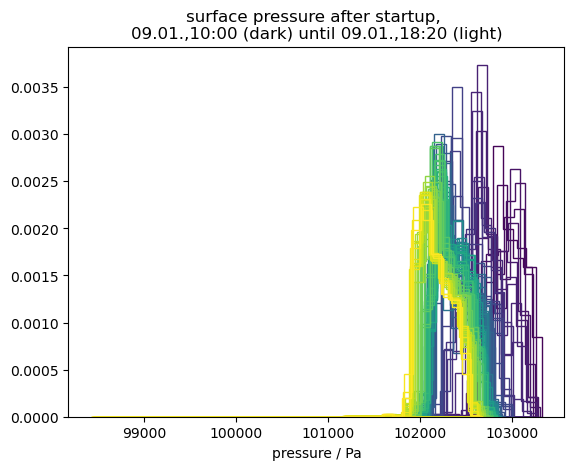

In [109]:
import importlib; importlib.reload(pu)
import matplotlib.pyplot as plt
import matplotlib 
cmap = matplotlib.colormaps['viridis']
import plot_utils as pu

def fixedfix_pres_sfc_after_startup():
    path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
    keywords = ['surface', 'DOM01']
    data = fh.disk_data_from_keywords(path, keywords)
    data = pp.replace_icon2datetime(data)

    fig, ax = plt.subplots()
    kwargs_general = dict(histtype='stepfilled', density=True, bins=40, fill=None)

    n = 100
    for i, t in enumerate(data.time.values[0:n]):
        kwargs = kwargs_general
        # kwargs['alpha'] = 1-(i+1)/n
        kwargs['edgecolor'] = cmap((i+1)/n)
        d = data['pres_sfc'].sel(time=t)
        ax.hist(d, **kwargs)
    ax.set_xlabel('pressure / Pa')
    ax.set_title(f'surface pressure after startup, \n{pu.datetime2str(data.time.values[0])} (dark) until {pu.datetime2str(data.time.values[n])} (light)')
    return fig, ax

fig, ax = fixedfix_pres_sfc_after_startup()
pu.savefig(fig, 'img/fixedfix_pres_sfc_after_startup.png')
fig.show()

In [108]:
help(pu.savefig)

Help on function savefig in module plot_utils:

savefig(fig, filename, overwrite=True)



In [64]:
import intake

# def create_catalog_content(data_dict):
#     """
#     Generate catalog content from a dictionary structure.

#     This function takes a dictionary structure where keys represent groups or categories,
#     and the corresponding values are dictionaries mapping dataset identifiers to file paths.
#     It generates a dictionary suitable for creating an Intake catalog using intake.open_catalog.

#     Parameters:
#     data_dict (dict): A dictionary structure containing dataset information.
#                       Keys represent groups or categories, and values are dictionaries
#                       mapping dataset identifiers to file paths.

#     Returns:
#     dict: A dictionary suitable for creating an Intake catalog using intake.open_catalog.
#           The generated dictionary follows the format required for Intake YAML catalog files.
#     """
#     catalog_content = {
#         "plugins": {
#             "source": [
#                 {"module": "intake_xarray"}
#             ]
#         },
#         "sources": {}
#     }

#     for group, datasets in data_dict.items():
#         catalog_content["sources"][group] = {}
#         for dataset_id, file_path in datasets.items():
#             catalog_content["sources"][group][dataset_id] = {
#                 "driver": "netcdf",
#                 "description": f"Dataset {group.upper()}{dataset_id}",
#                 "args": {"urlpath": file_path}
#             }

#     return catalog_content

def create_intake_catalog(data_dict, base_path=''):
    """
    Create an Intake catalog dictionary from a nested dictionary structure.

    Parameters:
        data_dict (dict): A nested dictionary representing datasets and their file paths.
                          The keys of the outer dictionary represent the dataset names,
                          and the keys of the inner dictionaries represent dataset versions
                          or identifiers, with corresponding values as relative file paths.
        base_path (str): Optional. A base path to prepend to all relative file paths.

    Returns:
        dict: A dictionary suitable for being passed to intake.open_catalog().

    Example:
        data_dict = {
            'a': {'1': 'a1.nc', '2': 'a2.nc'},
            'b': {'1': 'b1.nc', '2': 'b2.nc'}
        }
        catalog_dict = create_intake_catalog(data_dict)
        cat = intake.open_catalog(catalog_dict)
        # Access datasets using cat.a.1, cat.a.2, cat.b.1, cat.b.2
    """
    catalog_dict = {
        "plugins": {
            "source": [
                {"module": "intake_xarray"}
            ]
        },
        "sources": {}
    }

    for dataset, versions in data_dict.items():
        catalog_dict["sources"][dataset] = {}
        for version, filepath in versions.items():
            if base_path:
                filepath = f'{base_path}/{filepath}'
                
            catalog_dict["sources"][dataset][version] = {
                "driver": "netcdf",
                "description": f"Dataset {dataset.upper()}{version}",
                "args": {
                    "urlpath": f'file://{filepath}'
                }
            }

    return catalog_dict

import os

def create_intake_catalog(data_dict, base_path=''):
    """
    Create an Intake catalog dictionary from a nested dictionary structure.

    Parameters:
        data_dict (dict): A nested dictionary representing datasets and their file paths.
                          The keys of the outer dictionary represent the dataset names,
                          and the keys of the inner dictionaries represent dataset versions
                          or identifiers, with corresponding values as relative file paths.
        base_path (str): Optional. A base path to prepend to all relative file paths.

    Returns:
        dict: A dictionary suitable for being passed to intake.open_catalog().

    Example:
        data_dict = {
            'a': {'1': 'a1.nc', '2': 'a2.nc'},
            'b': {'1': 'b1.nc', '2': 'b2.nc'}
        }
        catalog_dict = create_intake_catalog(data_dict)
        cat = intake.open_catalog(catalog_dict)
        # Access datasets using cat.a.1, cat.a.2, cat.b.1, cat.b.2
    """
    catalog_dict = {
        "plugins": {
            "source": [
                {"module": "intake_xarray"}
            ]
        },
        "sources": {}
    }

    for dataset, versions in data_dict.items():
        catalog_dict["sources"][dataset] = {}
        for version, filepath in versions.items():
            if base_path:
                filepath = os.path.join(base_path, filepath)
            if not os.path.exists(filepath):
                raise ValueError(f"File not found: {filepath}")
            catalog_dict["sources"][dataset][version] = {
                "driver": "netcdf",
                "description": f"Dataset {dataset.upper()}{version}",
                "args": {
                    "urlpath": f'file://{filepath}'
                }
            }

    return catalog_dict

import os

def create_intake_catalog(data_dict, base_path=''):
    """
    Create an Intake catalog dictionary from a nested dictionary structure.

    Parameters:
        data_dict (dict): A dictionary representing datasets and their file paths.
                          If shallow, keys represent dataset names and values represent file paths.
                          If nested, keys of the outer dictionary represent dataset names,
                          and the keys of the inner dictionaries represent dataset versions
                          or identifiers, with corresponding values as relative file paths.
        base_path (str): Optional. A base path to prepend to all relative file paths.

    Returns:
        dict: A dictionary suitable for being passed to intake.open_catalog().

    Example:
        data_dict = {
            'latbc': 'data/profile_ctrl_latbc.nc',
            'ocean': {'1': 'data/ocean_1.nc', '2': 'data/ocean_2.nc'}
        }
        catalog_dict = create_intake_catalog(data_dict)
        cat = intake.open_catalog(catalog_dict)
        # Access datasets using cat.latbc, cat.ocean.1, cat.ocean.2
    """
    catalog_dict = {
        "plugins": {
            "source": [
                {"module": "intake_xarray"}
            ]
        },
        "sources": {}
    }

    if isinstance(data_dict, dict):
        for dataset, value in data_dict.items():
            if isinstance(value, dict):
                catalog_dict["sources"][dataset] = {}
                for version, filepath in value.items():
                    if base_path:
                        filepath = os.path.join(base_path, filepath)
                    if not os.path.exists(filepath):
                        raise ValueError(f"File not found: {filepath}")
                    catalog_dict["sources"][dataset][version] = {
                        "driver": "netcdf",
                        "description": f"Dataset {dataset.upper()}{version}",
                        "args": {
                            "urlpath": f'file://{filepath}'
                        }
                    }
            elif isinstance(value, str):
                if base_path:
                    filepath = os.path.join(base_path, value)
                if not os.path.exists(filepath):
                    raise ValueError(f"File not found: {filepath}")
                catalog_dict["sources"][dataset] = {
                    "driver": "netcdf",
                    "description": f"Dataset {dataset.upper()}",
                    "args": {
                        "urlpath": f'file://{filepath}'
                    }
                }
            else:
                raise ValueError("Invalid data_dict format. Expected a dictionary or nested dictionaries.")
    else:
        raise ValueError("Invalid data_dict format. Expected a dictionary or nested dictionaries.")

    return catalog_dict


def create_intake_catalog(data_dict, base_path=''):
    """
    Create an Intake catalog dictionary from a nested dictionary structure.

    Parameters:
        data_dict (dict): A nested dictionary representing datasets and their file paths.
                          The keys of the outer dictionary represent the dataset names,
                          and the keys of the inner dictionaries represent dataset versions
                          or identifiers, with corresponding values as relative file paths.
        base_path (str): Optional. A base path to prepend to all relative file paths.

    Returns:
        dict: A dictionary suitable for being passed to intake.open_catalog().

    Example:
        data_dict = {
            'a': {'1': 'a1.nc', '2': 'a2.nc'},
            'b': {'1': 'b1.nc', '2': 'b2.nc'}
        }
        catalog_dict = create_intake_catalog(data_dict)
        cat = intake.open_catalog(catalog_dict)
        # Access datasets using cat.a.1, cat.a.2, cat.b.1, cat.b.2
    """
    catalog_dict = {
        "plugins": {
            "source": [
                {"module": "intake_xarray"}
            ]
        },
        "sources": {}
    }

    for dataset, versions in data_dict.items():
        catalog_dict["sources"][dataset] = {}
        for version, filepath in versions.items():
            if base_path:
                filepath = f'{base_path}/{filepath}'
            catalog_dict["sources"][dataset][version] = {
                "driver": "netcdf",
                "description": f"Dataset {dataset.upper()}{version}",
                "args": {
                    "urlpath": filepath
                }
            }

    # Add dummy drivers for top-level entries
    for dataset in data_dict:
        catalog_dict["sources"][dataset] = {
            "driver": "dummy",
            "description": f"Group {dataset}"
        }

    return catalog_dict

# Usage example:
data_dict = {
    'a': {'1': 'a1.nc', '2': 'a2.nc'},
    'b': {'1': 'b1.nc', '2': 'b2.nc'}
}
catalog_dict = create_intake_catalog(data_dict, base_path='.')
cat = intake.catalog.Catalog.from_dict(catalog_dict)
cat

# import importlib; importlib.reload(fh)
# # Example usage:
# data_dict = {'a': {'1': 'a1.nc', '2': 'a2.nc'}, 'b': {'1': 'b1.nc', '2': 'b2.nc'}}
# data_dict = {'ctrl': {'latbc': f'data/profile_ctrl_latbc_{stamp()}.nc',
#                       'initc': f'data/profile_warm_latbc_{stamp()}.nc'},
#              'warm': {'latbc': f'data/profile_ctrl_initcon_{stamp()}.nc', 
#                       'initc': f'data/profile_warm_initcon_{stamp()}.nc'}}
# # data_dict = {'latbc' : f'data/profile_ctrl_latbc.nc'}
# # data_dict = {'latbc' : f'data/profile_ctrl_latbc_{stamp()}.nc'}
# fh.print_nested_dict(data_dict)
# base_path = os.getcwd()
# catalog_dict = create_intake_catalog(data_dict, base_path=base_path)

# fh.print_nested_dict(catalog_dict, method='json')
# # cat = intake.open_catalog(catalog_content)
# cat = intake.catalog.Catalog.from_dict(catalog_dict)
# # list(cat)
# # catalog_dict
# cat

null:
  args: {}
  description: ''
  driver: intake.catalog.base.Catalog
  metadata: {}


In [61]:
list(intake.open_catalog('/scratch/m/m300872/intake_test.yml'))

ValidationError: Catalog '/scratch/m/m300872/intake_test.yml' has validation errors:

("missing required key 'driver'", {'latbc': {'driver': 'netcdf', 'description': 'Dataset CTRLlatbc', 'args': {'urlpath': 'file:///home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/profile_ctrl_latbc_202403.nc'}}, 'initc': {'driver': 'netcdf', 'description': 'Dataset CTRLinitc', 'args': {'urlpath': 'file:///home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/profile_warm_latbc_202403.nc'}}})
("missing required key 'driver'", {'latbc': {'driver': 'netcdf', 'description': 'Dataset WARMlatbc', 'args': {'urlpath': 'file:///home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/profile_ctrl_initcon_202403.nc'}}, 'initc': {'driver': 'netcdf', 'description': 'Dataset WARMinitc', 'args': {'urlpath': 'file:///home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/profile_warm_initcon_202403.nc'}}})

In [14]:
data_dict = {
    'a': {'1': 'a1.nc', '2': 'a2.nc'},
    'b': {'1': 'b1.nc', '2': 'b2.nc'}
}
fh.print_nested_dict(data_dict)

├── a
│   ├── 1
│   │   a1.nc
│   └── 2
│       a2.nc
└── b
    ├── 1
    │   b1.nc
    └── 2
        b2.nc


In [51]:
import json

def print_catalog_dict(catalog_dict):
    """
    Print the catalog dictionary in a formatted way.

    Parameters:
        catalog_dict (dict): The catalog dictionary to print.
    """
    print(json.dumps(catalog_dict, indent=4))
    
print_catalog_dict(catalog_content)

{
    "plugins": {
        "source": [
            {
                "module": "intake_xarray"
            }
        ]
    },
    "sources": {
        "latbc": {
            "driver": "netcdf",
            "description": "Dataset LATBC",
            "args": {
                "urlpath": "file:///home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/profile_ctrl_latbc_202403.nc"
            }
        }
    }
}


In [43]:
import intake

def create_intake_catalog(data_dict, base_path=''):
    """
    Create an Intake catalog from a nested dictionary structure.

    Parameters:
        data_dict (dict): A nested dictionary representing datasets and their file paths.
                          The keys of the outer dictionary represent the dataset names,
                          and the keys of the inner dictionaries represent dataset versions
                          or identifiers, with corresponding values as relative file paths.
        base_path (str): Optional. A base path to prepend to all relative file paths.

    Returns:
        intake.catalog.Catalog: An Intake catalog object.

    Example:
        data_dict = {
            'a': {'1': 'a1.nc', '2': 'a2.nc'},
            'b': {'1': 'b1.nc', '2': 'b2.nc'}
        }
        cat = create_intake_catalog(data_dict)
        # Access datasets using cat.a.1, cat.a.2, cat.b.1, cat.b.2
    """
    catalog_dict = {
        "plugins": {
            "source": [
                {"module": "intake_xarray"}
            ]
        },
        "sources": {}
    }

    for dataset, versions in data_dict.items():
        catalog_dict["sources"][dataset] = {}
        for version, filepath in versions.items():
            if base_path:
                filepath = f'{base_path}/{filepath}'
            catalog_dict["sources"][dataset][version] = {
                "driver": "netcdf",
                "description": f"Dataset {dataset.upper()}{version}",
                "args": {
                    "urlpath": filepath
                }
            }

    return intake.catalog.Catalog.from_dict(catalog_dict)

# Usage example:
data_dict = {'latbc': 'data/profile_ctrl_latbc.nc'}
help(fh) #.create_intake_catalog(data_dict, base_path='.')


Help on module file_handling:

NAME
    file_handling - Utility Module for Data Processing and Job Management

DESCRIPTION
    This module provides a collection of utility functions for various tasks, including handling files and directories,
    calculating hash values, generating SLURM job headers, and interacting with SLURM job schedulers. It also includes a
    custom catalog class for organizing and accessing datasets and functions to load data based on keywords and match file
    extensions.
    
    Functions:
    - all_module_files(directory, suffix): Load the text content of all source files in a directory.
    - archive_file(file_path, save_directory): Archives a file to a specified directory.
    - basename(path, extension, include_extension): Get the base name of a file path with or without the file extension.
    - beep(fr, sec): Play a sound alarm to notify when a cell has finished execution (I get distracted).
    - check_queue(user): Retrieves job queue information for 

In [49]:
data_dict = {'latbc': 'data/profile_ctrl_latbc.nc'}

data_dict = {'latbc' : f'data/profile_ctrl_latbc_{stamp()}.nc'}
catalog_dict = create_intake_catalog(data_dict, base_path='.')
print(catalog_dict)

cat = intake.open_catalog(catalog_dict)

{'plugins': {'source': [{'module': 'intake_xarray'}]}, 'sources': {'latbc': {'driver': 'netcdf', 'description': 'Dataset LATBC', 'args': {'urlpath': 'file://./data/profile_ctrl_latbc_202403.nc'}}}}


ValueError: URI not understood: {'plugins': {'source': [{'module': 'intake_xarray'}]}, 'sources': {'latbc': {'driver': 'netcdf', 'description': 'Dataset LATBC', 'args': {'urlpath': 'file://./data/profile_ctrl_latbc_202403.nc'}}}}

In [ ]:
import os
import sys
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)
import file_handling as fh
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import postprocessing as pp
import calculations as cc

ifile = '/work/mh1126/m300872/unchanged/initc/20200109/initc_EUREC4A_PR1250m_DOM01_2020010910.nc'
ofile = '/home/m/m300872/warm_eurec4a/03_adiabatic_warming/data/profile_ctrl_latbc_202403.nc'

data = xr.open_dataset(ifile).isel(time=0)
dims = [dim for dim in data.dims if 'cell' in dim]
data = data.mean(dim=['ncells', 'ncells_2'])
if 'latbc' in ifile: varnames = {'pressure' : 'p'}
else: {'pressure' : 'pres'}
data = cc.add_full_level_height(data, varnames={'pressure' : 'p'})
try:
    data.to_netcdf(ofile)
except: 
    os.remove(ofile)
    data.to_netcdf(ofile)

In [14]:
help(fh)

Help on module file_handling:

NAME
    file_handling - Utility Module for Data Processing and Job Management

DESCRIPTION
    This module provides a collection of utility functions for various tasks, including handling files and directories,
    calculating hash values, generating SLURM job headers, and interacting with SLURM job schedulers. It also includes a
    custom catalog class for organizing and accessing datasets and functions to load data based on keywords and match file
    extensions.
    
    Functions:
    - disable_warnings(): Disable warnings issued by Python's 'warnings' module.
    - get_hash(string): Compute the SHA-1 hash of a given string and return it as a hexadecimal string.
    - basename(path, extension=True, include_extension=None): Get the base name of a file path with or without the file
      extension.
    - dirname(path): Get the directory name of a file path.
    - extension(path, include_dot=True): Get the file extension of a file path.
    - is_netcdf

In [ ]:
data